In [284]:
import matplotlib.pyplot as plt
import pickle as pkl
import random
import math
import json
import pandas as pd
import numpy as np

from mytester import Tester

from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [154]:
with open('train.pkl', 'rb') as f:
    train = pkl.load(f)
with open('test.pkl', 'rb') as f:
    test = pkl.load(f)

In [264]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [165]:
counter = Counter()
for item in train:
    for k, v in item.features.items():
        if v != '' and v != 'None' and v != None:
            counter[k] += 1
counter.most_common(40)

In [214]:
def get_weight(item):
    weight = item.features.get('Item Weight')
    if weight:
        parts = weight.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        match unit:
            case 'pounds':
                return amount
            case 'ounces':
                return amount / 16
            case 'kilograms':
                return amount / 0.453592
            case 'milligrams':
                return amount / 453592
            case 'grams':
                return amount / 453.592
            # case 'tons':
            #     return amount * 2000
            case 'hundredths':
                return amount / 100
            case _:
                pass
                # print(weight)
        return None

In [215]:
weights = [get_weight(item) for item in train]
weights = [w for w in weights if w]
avr_weight = sum(weights) / len(weights)
print(avr_weight)

13.645832705345374


In [252]:
def get_weight_or_average(item):
    return get_weight(item) or avr_weight
get_weight_or_averate(train[100])

4.0

In [ ]:
brand_counter = Counter()
for item in train:
    brand = item.features.get('Brand')
    if brand:
       brand_counter[brand] += 1

print(len(brand_counter))
brand_counter.most_common(40)

In [224]:
TOP_BRANDS = ('hp', 'dell', 'lenovo', 'asus', 'sony', 'canon', 'apple',
             'samsung', 'intel', )
def is_top_brand(item):
    brand = item.features.get('Brand')
    return brand and brand.lower() in TOP_BRANDS
is_top_brand(train[1])

False

In [225]:
train[1].features.get('Best Sellers Rank')

{'Office Products': 262695, 'Inkjet Printer Ink Cartridges': 9704}

In [ ]:
rank_counter = Counter()
for item in train:
    ranks = item.features.get('Best Sellers Rank')
    if ranks:
        for rank in ranks:
            rank_counter[rank] += 1

print(len(rank_counter))
rank_counter.most_common(40)

In [239]:
def get_rank(item):
    ranks = item.features.get('Best Sellers Rank')
    if ranks:
        return sum(ranks.values()) / len(ranks)
    return None
get_rank(train[0])

271889.0

In [238]:
ranks = [r for item in train if (r := get_rank(item))]
avr_rank = sum(ranks) /len(ranks)
avr_rank

377178.03745133284

In [240]:
def get_rank_or_average(item):
    rank = get_rank(item)
    return rank or avr_rank

In [259]:
def get_text_length(item):
    return len(item.test_prompt())

In [260]:
def get_features(item):
    return {
        "weight": get_weight_or_average(item),
        "rank": get_rank_or_average(item),
        "text_length": get_text_length(item),
        "is_top_brand": 1 if is_top_brand(item) else 0
    }
get_features(train[0])

{'weight': 2.9, 'rank': 271889.0, 'text_length': 677, 'is_top_brand': 0}

In [265]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test)

In [274]:
print(len(test))
print(len(test_df))

2000
2000


In [285]:
np.random.seed(37)
feature_columns = ['weight', 'rank', 'text_length', 'is_top_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef:.7f}")
print(f"Intercept: {model.intercept_}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

weight: 0.2680288
rank: 0.0000529
text_length: -0.0137750
is_top_brand: 198.1860256
Intercept: 197.12762659221934
Mean Squared Error: 32403.57660083049
Mean Absolute Error: 135.15718185707735
R-squared Score: 0.06892202084425403


In [277]:
def linear_regression_pricer(item):
    features = get_features(item)
    item_df = pd.DataFrame([features])
    return model.predict(item_df)[0]

Guess = $210.07, Truth = $162.65, Error = $47.42 for Item: Garage-Pro Rear Bumper Step Pad Set of 2 Compatibl...
Guess = $212.98, Truth = $348.37, Error = $135.39 for Item: Draw-Tite 75681 Max-Frame Receiver
Guess = $225.31, Truth = $329.00, Error = $103.69 for Item: Blue Ocean 63” Stainless Steel SPS8863 Thermostati...
Guess = $193.88, Truth = $49.99, Error = $143.89 for Item: 3M Laser/Ppc Film Clear 50 Sheets
Guess = $189.88, Truth = $65.99, Error = $123.89 for Item: DURATECH 76-Piece Tap and Die Set, Metric and Stan...
Guess = $206.13, Truth = $199.99, Error = $6.14 for Item: K&N Cold Air Intake Kit: High Performance, Guarant...
Guess = $211.94, Truth = $118.30, Error = $93.64 for Item: Vortex GC510K V3 Black Gas Cap for Suzuki Motorcyc...
Guess = $189.37, Truth = $103.99, Error = $85.38 for Item: Brother LC3033 BK/C/M/Y Super High Yield Ink-4 Pac...
Guess = $408.72, Truth = $999.00, Error = $590.28 for Item: DELL Precision M5510 4K 3840X2160 Touchscreen XEON...
Guess = $231.72, Tru

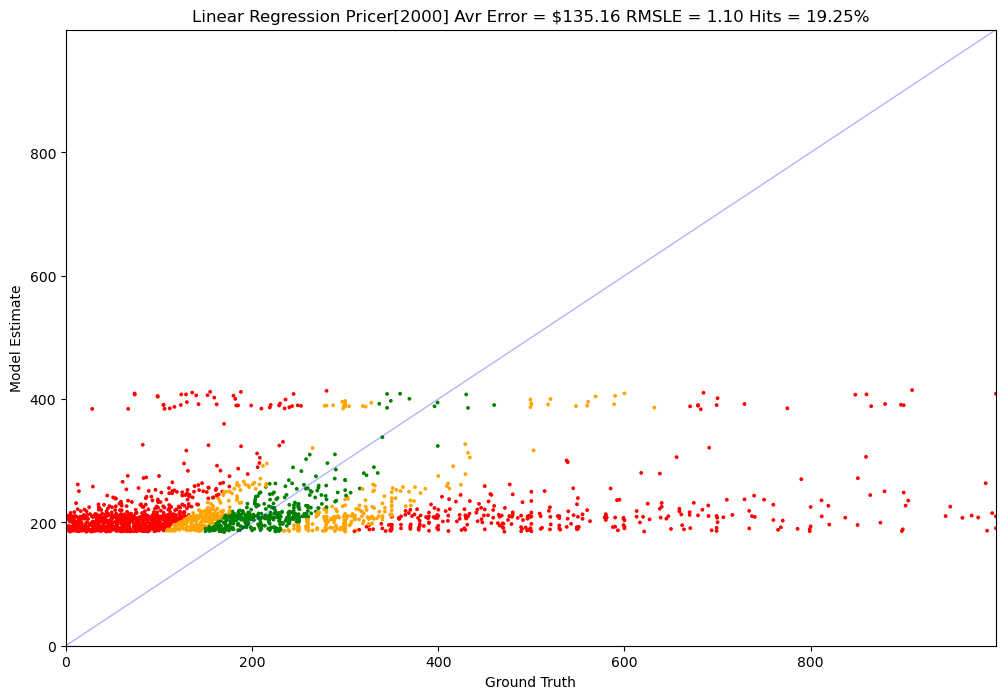

In [287]:
tester = Tester(test, 2000)
tester.test(linear_regression_pricer)

In [300]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [313]:
np.random.seed(37)
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [314]:
print(type(X))
print(X.shape)
print(type(prices[0]))

<class 'scipy.sparse._csr.csr_matrix'>
(400000, 1000)
<class 'numpy.float64'>


Guess = $197.56, Truth = $162.65, Error = $34.91 for Item: Garage-Pro Rear Bumper Step Pad Set of 2 Compatibl...
Guess = $358.28, Truth = $348.37, Error = $9.91 for Item: Draw-Tite 75681 Max-Frame Receiver
Guess = $420.68, Truth = $329.00, Error = $91.68 for Item: Blue Ocean 63” Stainless Steel SPS8863 Thermostati...
Guess = $142.98, Truth = $49.99, Error = $92.99 for Item: 3M Laser/Ppc Film Clear 50 Sheets
Guess = $233.72, Truth = $65.99, Error = $167.73 for Item: DURATECH 76-Piece Tap and Die Set, Metric and Stan...
Guess = $373.47, Truth = $199.99, Error = $173.48 for Item: K&N Cold Air Intake Kit: High Performance, Guarant...
Guess = $241.65, Truth = $118.30, Error = $123.35 for Item: Vortex GC510K V3 Black Gas Cap for Suzuki Motorcyc...
Guess = $47.84, Truth = $103.99, Error = $56.15 for Item: Brother LC3033 BK/C/M/Y Super High Yield Ink-4 Pac...
Guess = $467.46, Truth = $999.00, Error = $531.54 for Item: DELL Precision M5510 4K 3840X2160 Touchscreen XEON...
Guess = $198.62, Truth

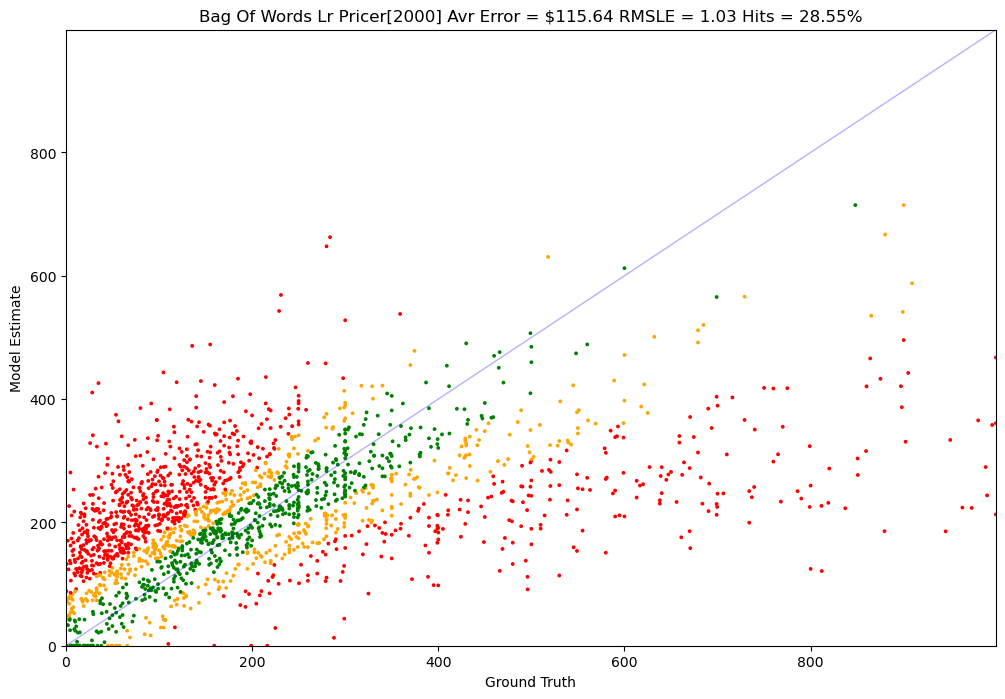

In [315]:
tester = Tester(test, 2000)
def bag_of_words_LR_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)
tester.test(bag_of_words_LR_pricer)

In [316]:
np.random.seed(37)
processed_docs = [simple_preprocess(doc) for doc in documents]
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)


In [321]:
print(w2v_model.vector_size)
print(w2v_model.wv)

400
KeyedVectors<vector_size=400, 290957 keys>


In [335]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zero(w2v_model.vector_size)

X_w2v = np.array([document_vector(doc) for doc in documents])

In [336]:
print(X_w2v.shape)

(400000, 400)


In [323]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


219.2098
Guess = $166.19, Truth = $162.65, Error = $3.54 for Item: Garage-Pro Rear Bumper Step Pad Set of 2 Compatibl...
Guess = $358.02, Truth = $348.37, Error = $9.65 for Item: Draw-Tite 75681 Max-Frame Receiver
Guess = $312.33, Truth = $329.00, Error = $16.67 for Item: Blue Ocean 63” Stainless Steel SPS8863 Thermostati...
Guess = $125.02, Truth = $49.99, Error = $75.03 for Item: 3M Laser/Ppc Film Clear 50 Sheets
Guess = $136.97, Truth = $65.99, Error = $70.98 for Item: DURATECH 76-Piece Tap and Die Set, Metric and Stan...
Guess = $346.02, Truth = $199.99, Error = $146.03 for Item: K&N Cold Air Intake Kit: High Performance, Guarant...
Guess = $186.32, Truth = $118.30, Error = $68.02 for Item: Vortex GC510K V3 Black Gas Cap for Suzuki Motorcyc...
Guess = $48.61, Truth = $103.99, Error = $55.38 for Item: Brother LC3033 BK/C/M/Y Super High Yield Ink-4 Pac...
Guess = $532.46, Truth = $999.00, Error = $466.54 for Item: DELL Precision M5510 4K 3840X2160 Touchscreen XEON...
Guess = $111.25,

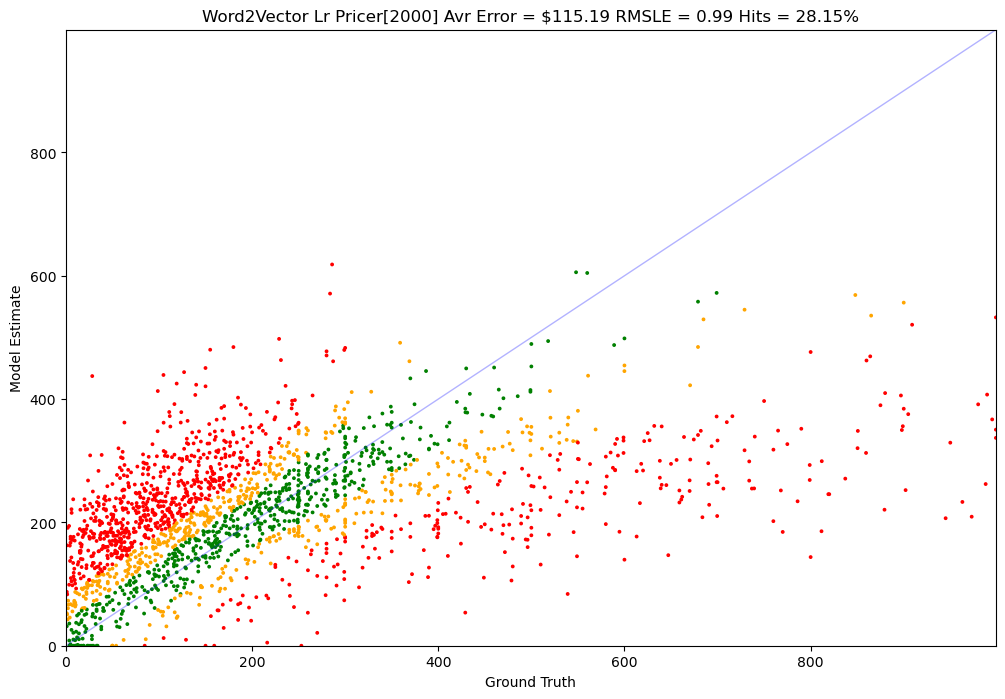

In [338]:
tester = Tester(test, 2000)
def word2vector_lr_pricer(item):
    vector = document_vector(item.test_prompt())
    return max(word2vec_lr_regressor.predict([vector])[0], 0)
    
print(word2vector_lr_pricer(train[0]))
tester.test(word2vector_lr_pricer)

In [340]:
np.random.seed(37)
svr_regressor = LinearSVR()
svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


Guess = $164.01, Truth = $162.65, Error = $1.36 for Item: Garage-Pro Rear Bumper Step Pad Set of 2 Compatibl...
Guess = $265.63, Truth = $348.37, Error = $82.74 for Item: Draw-Tite 75681 Max-Frame Receiver
Guess = $250.32, Truth = $329.00, Error = $78.68 for Item: Blue Ocean 63” Stainless Steel SPS8863 Thermostati...
Guess = $110.10, Truth = $49.99, Error = $60.11 for Item: 3M Laser/Ppc Film Clear 50 Sheets
Guess = $113.55, Truth = $65.99, Error = $47.56 for Item: DURATECH 76-Piece Tap and Die Set, Metric and Stan...
Guess = $327.04, Truth = $199.99, Error = $127.05 for Item: K&N Cold Air Intake Kit: High Performance, Guarant...
Guess = $169.41, Truth = $118.30, Error = $51.11 for Item: Vortex GC510K V3 Black Gas Cap for Suzuki Motorcyc...
Guess = $55.69, Truth = $103.99, Error = $48.30 for Item: Brother LC3033 BK/C/M/Y Super High Yield Ink-4 Pac...
Guess = $468.68, Truth = $999.00, Error = $530.32 for Item: DELL Precision M5510 4K 3840X2160 Touchscreen XEON...
Guess = $119.95, Truth =

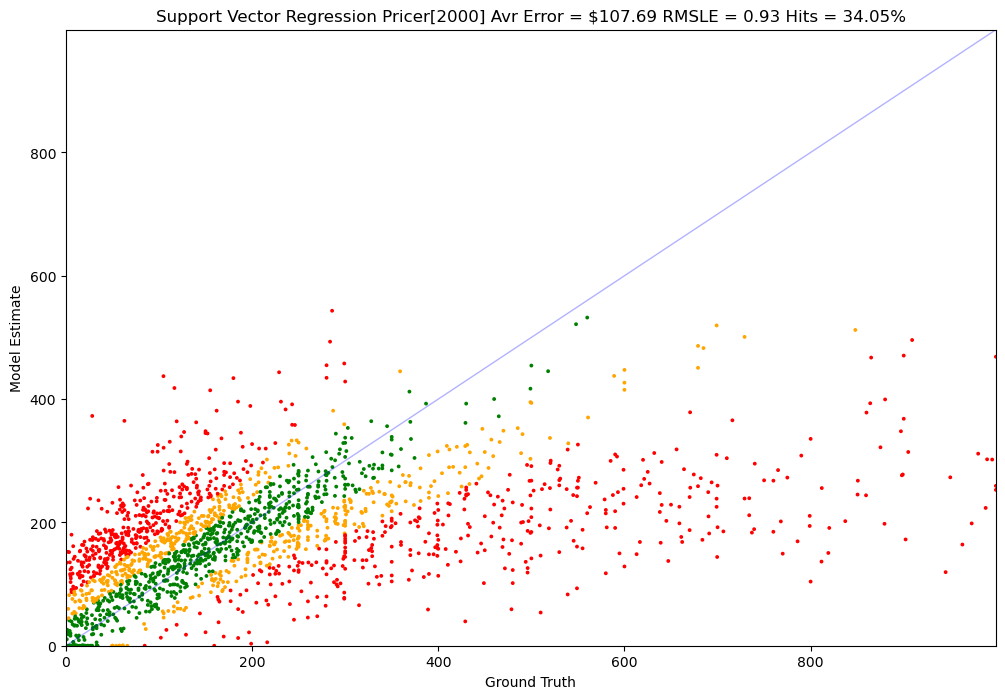

In [342]:
def support_vector_regression_pricer(item):
    vector = document_vector(item.test_prompt())
    return max(svr_regressor.predict([vector])[0], 0)
tester.test(support_vector_regression_pricer)

In [345]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=37, n_jobs=8)
rf_model.fit(X_w2v, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


219.39160000000018
Guess = $253.93, Truth = $162.65, Error = $91.28 for Item: Garage-Pro Rear Bumper Step Pad Set of 2 Compatibl...
Guess = $266.95, Truth = $348.37, Error = $81.42 for Item: Draw-Tite 75681 Max-Frame Receiver
Guess = $355.06, Truth = $329.00, Error = $26.06 for Item: Blue Ocean 63” Stainless Steel SPS8863 Thermostati...
Guess = $109.13, Truth = $49.99, Error = $59.14 for Item: 3M Laser/Ppc Film Clear 50 Sheets
Guess = $104.35, Truth = $65.99, Error = $38.36 for Item: DURATECH 76-Piece Tap and Die Set, Metric and Stan...
Guess = $292.89, Truth = $199.99, Error = $92.90 for Item: K&N Cold Air Intake Kit: High Performance, Guarant...
Guess = $223.44, Truth = $118.30, Error = $105.14 for Item: Vortex GC510K V3 Black Gas Cap for Suzuki Motorcyc...
Guess = $129.87, Truth = $103.99, Error = $25.88 for Item: Brother LC3033 BK/C/M/Y Super High Yield Ink-4 Pac...
Guess = $487.77, Truth = $999.00, Error = $511.23 for Item: DELL Precision M5510 4K 3840X2160 Touchscreen XEON...
Gue

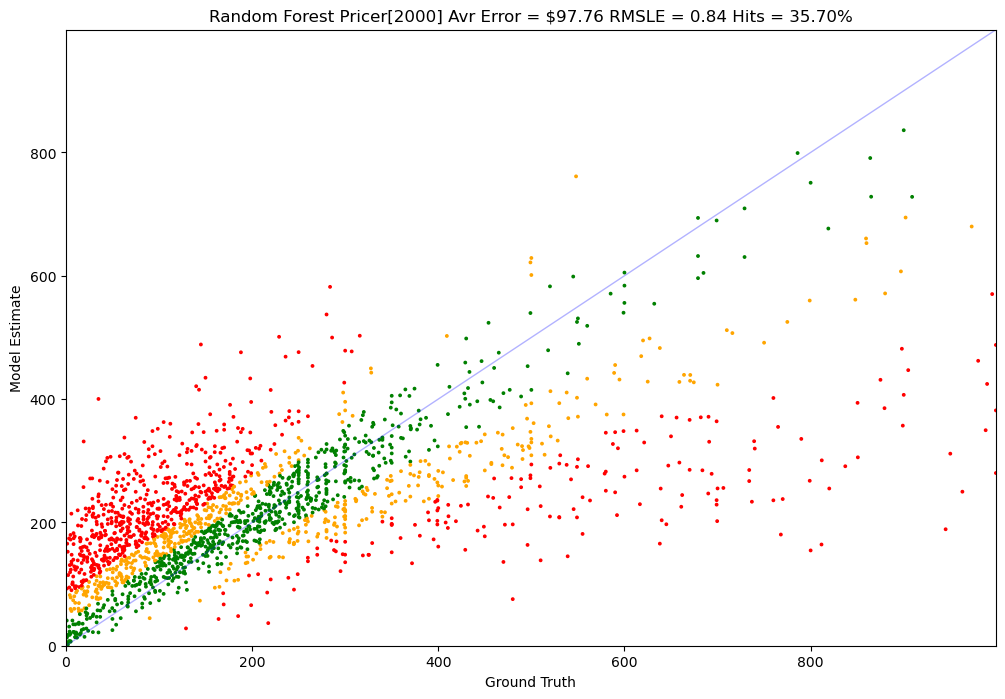

In [346]:
def random_forest_pricer(item):
    vector = document_vector(item.test_prompt())
    return max(rf_model.predict([vector])[0], 0)
print(random_forest_pricer(train[0]))
tester.test(random_forest_pricer)

Guess = $96.40, Truth = $11.00, Error = $85.40 for Item: Risbay Cabinet Pull,2Pcs 5.43"×1.57" Golden Zinc A...
Guess = $274.90, Truth = $165.00, Error = $109.90 for Item: Acquaer 1HP Shallow Well Jet Pump,Cast Iron, Well ...
Guess = $132.59, Truth = $163.00, Error = $30.41 for Item: Mould King 13138 Model Ships Kits to Build for Kid...


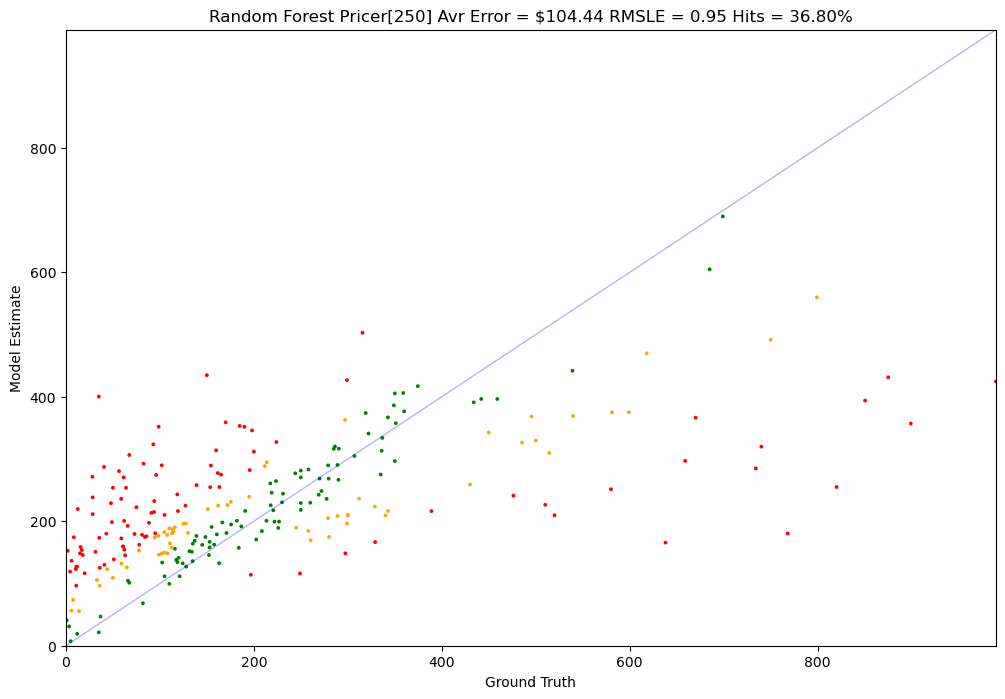

In [349]:
tester = Tester(test[250:], 250)
def random_forest_pricer(item):
    vector = document_vector(item.test_prompt())
    return max(rf_model.predict([vector])[0], 0)
tester.test(random_forest_pricer)